In [32]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional

In [10]:
url = "https://raw.githubusercontent.com/muhammadisa/threatmsgdetect/main/message-dataset.csv"
messages = pd.read_csv(url)
messages[:10]

,message,label
0,"Woy ngentot bayar gak, gw sebar foto2 lu",threat
1,oi jamet bayar gak lo skrg?!,threat
2,hati hati anda saya gak segan mencelakai anda,threat
3,kirim uang 100 juta jika tidak bom akan dikiri...,threat
4,Liat aja klo gak bayar bakal terjadi hal buruk...,threat
5,Woy ngentot,threat
6,"ANAK ANJING, BAYAR UTANG LU SEKARANG ATAU MAU ...",threat
7,"Pokoknya lu harus tanggung jawab, kalo engga g...",threat
8,Bangsat lu ya!,threat
9,Jancok,threat


In [11]:
messages.describe()

,message,label
count,80,80
unique,80,2
top,hah cape banget gw belom lagi besok skripsi,threat
freq,1,48


In [12]:
duplicatedRow = messages[messages.duplicated()]
print(duplicatedRow[:5])

Empty DataFrame
Columns: [message, label]
Index: []


In [14]:
messages.groupby('label').describe().T

label                                                netral  \
message count                                            32   
        unique                                           32   
        top     hah cape banget gw belom lagi besok skripsi   
        freq                                              1   

label                                                      threat  
message count                                                  48  
        unique                                                 48  
        top     kami tidak akan segan menyakiti keluarga anda ...  
        freq                                                    1

In [27]:
# Get all the ham and spam emails
threat_msg = messages[messages.label =='threat']
netral_msg = messages[messages.label=='netral']

# Create numpy list to visualize using wordcloud
threat_msg_text = " ".join(threat_msg.message.to_numpy().tolist())
netral_msg_text = " ".join(netral_msg.message.to_numpy().tolist())

In [29]:
factoryStopword = StopWordRemoverFactory()
stopwords = factoryStopword.get_stop_words()

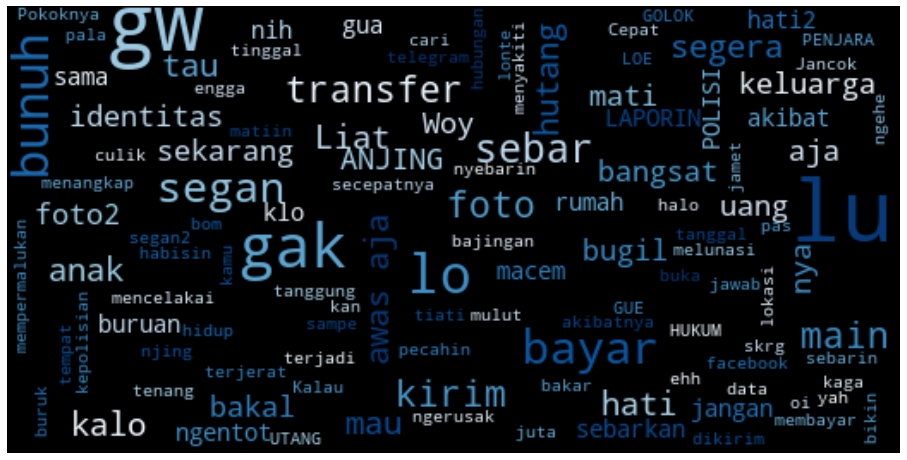

In [33]:
# wordcloud of threat messages
threat_msg_cloud = WordCloud(width =520, height =260, stopwords=stopwords, max_font_size=50, background_color ="black", colormap='Blues').generate(threat_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(threat_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

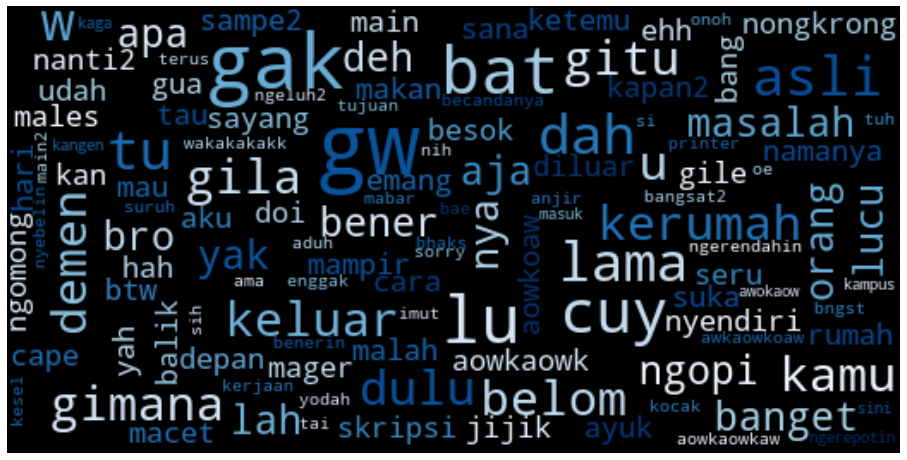

In [34]:
# wordcloud of netral messages
netral_msg_cloud = WordCloud(width =520, height =260, stopwords=stopwords,max_font_size=50, background_color ="black", colormap='Blues').generate(netral_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(netral_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

/home/stoic/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


150.0

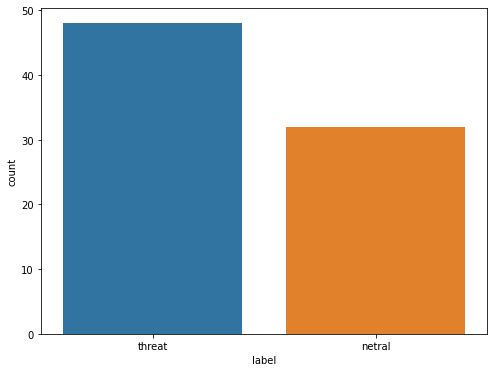

In [35]:
# we can observe imbalance data here 
plt.figure(figsize=(8,6))
sns.countplot(messages.label)
# Percentage of threat messages
(len(threat_msg)/len(netral_msg))*100 # 15.48%

In [73]:
# netral_msg_df = netral_msg
# threat_msg_df = threat_msg
# print(threat_msg_df.shape, netral_msg_df.shape)

netral_msg_df = netral_msg.sample(n = len(threat_msg), random_state = 44, replace=True)
threat_msg_df = threat_msg
print(threat_msg_df.shape, netral_msg_df.shape)

(48, 2) (48, 2)


/home/stoic/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'Message types')

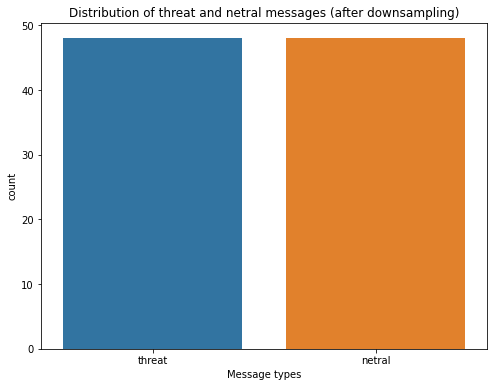

In [74]:
# Create a dataframe with these threat and netral msg
msg_df = threat_msg_df.append(netral_msg_df).reset_index(drop=True)
plt.figure(figsize=(8,6))
sns.countplot(msg_df.label)
plt.title('Distribution of threat and netral messages (after downsampling)')
plt.xlabel('Message types')

In [75]:
# Get length column for each text
msg_df['text_length'] = msg_df['message'].apply(len)
#Calculate average length by label types
labels = msg_df.groupby('label').mean()
labels

,text_length
label,
netral,36.916667
threat,41.562500


In [76]:
# Map netral label as 0 and threat as 1
msg_df['msg_type']= msg_df['label'].map({'netral': 0, 'threat': 1})
msg_label = msg_df['msg_type'].values

In [77]:
train_msg, test_msg, train_labels, test_labels = train_test_split(msg_df['message'], msg_label, test_size=0.3, random_state=10)

In [78]:
# Defining pre-processing hyperparameters
max_len = 50 
trunc_type = "post" 
padding_type = "post" 
oov_tok = "<OOV>" 
vocab_size = 500

In [79]:
tokenizer = Tokenizer(num_words = vocab_size, char_level=False, oov_token = oov_tok)
tokenizer.fit_on_texts(train_msg)

In [80]:
# Get the word_index 
word_index = tokenizer.word_index
word_index

{'<OOV>': 1,
 'gw': 2,
 'lu': 3,
 'gak': 4,
 'ya': 5,
 'lo': 6,
 'bunuh': 7,
 'di': 8,
 'cuy': 9,
 'dulu': 10,
 'nya': 11,
 'aja': 12,
 'lagi': 13,
 'kerumah': 14,
 'tau': 15,
 'saya': 16,
 'asli': 17,
 'ke': 18,
 'bat': 19,
 'akan': 20,
 'ada': 21,
 'anda': 22,
 'sebar': 23,
 'tu': 24,
 'dah': 25,
 'mau': 26,
 'nih': 27,
 'bayar': 28,
 'awas': 29,
 'gitu': 30,
 'tidak': 31,
 'transfer': 32,
 'bener': 33,
 'orang': 34,
 'liat': 35,
 'main': 36,
 'nanti': 37,
 'anak': 38,
 'kirim': 39,
 'bakal': 40,
 'tuh': 41,
 'karena': 42,
 'tujuan': 43,
 'kami': 44,
 'foto': 45,
 'kalo': 46,
 'demen': 47,
 'gua': 48,
 'dimana': 49,
 'bang': 50,
 'depan': 51,
 'rumah': 52,
 'u': 53,
 'keluar': 54,
 'balik': 55,
 'segan': 56,
 'yak': 57,
 'gila': 58,
 'lucu': 59,
 'kamu': 60,
 'belom': 61,
 'gimana': 62,
 'mampir': 63,
 'doi': 64,
 'uang': 65,
 'yang': 66,
 'klo': 67,
 'sama': 68,
 'keluarga': 69,
 'woy': 70,
 'ngentot': 71,
 'anjing': 72,
 'bangsat': 73,
 'akibat': 74,
 'yah': 75,
 'hati2': 76,
 'jik

In [81]:
# check how many words 
tot_words = len(word_index)
print('There are %s unique tokens in training data. ' % tot_words)

There are 194 unique tokens in training data. 


In [82]:
# Sequencing and padding on training and testing 
training_sequences = tokenizer.texts_to_sequences(train_msg)
training_padded = pad_sequences(training_sequences, maxlen = max_len, padding = padding_type, truncating = trunc_type )

testing_sequences = tokenizer.texts_to_sequences(test_msg)
testing_padded = pad_sequences(testing_sequences, maxlen = max_len,
                               
padding = padding_type, truncating = trunc_type)

In [83]:
# Shape of train tensor
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

Shape of training tensor:  (67, 50)
Shape of testing tensor:  (29, 50)


In [84]:
# Before padding
len(training_sequences[0]), len(training_sequences[1])

(12, 7)

In [85]:
# After padding
len(training_padded[0]), len(training_padded[1])

(50, 50)

In [86]:
print(training_padded[0])

[24 34 17 18 97 19 98 58  4 59 19 99  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0]


In [87]:
vocab_size = 500 # As defined earlier
embeding_dim = 16
drop_value = 0.2 # dropout
n_dense = 24

In [89]:
#Dense model architecture
model = Sequential()
model.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid'))

In [90]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 16)            8000      
_________________________________________________________________
global_average_pooling1d_2 ( (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 24)                408       
_________________________________________________________________
dropout_2 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 25        
Total params: 8,433
Trainable params: 8,433
Non-trainable params: 0
_________________________________________________________________


In [91]:
model.compile(loss='binary_crossentropy',optimizer='adam' ,metrics=['accuracy'])

In [92]:
# fitting a dense spam detector model
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(training_padded, train_labels, epochs=num_epochs, validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30
3/3 - 4s - loss: 0.6942 - accuracy: 0.3881 - val_loss: 0.6927 - val_accuracy: 0.5172
Epoch 2/30
3/3 - 0s - loss: 0.6920 - accuracy: 0.4776 - val_loss: 0.6925 - val_accuracy: 0.8276
Epoch 3/30
3/3 - 0s - loss: 0.6923 - accuracy: 0.6119 - val_loss: 0.6923 - val_accuracy: 0.8621
Epoch 4/30
3/3 - 0s - loss: 0.6913 - accuracy: 0.6866 - val_loss: 0.6920 - val_accuracy: 0.5517
Epoch 5/30
3/3 - 0s - loss: 0.6926 - accuracy: 0.5821 - val_loss: 0.6917 - val_accuracy: 0.5172
Epoch 6/30
3/3 - 0s - loss: 0.6924 - accuracy: 0.4925 - val_loss: 0.6914 - val_accuracy: 0.5172
Epoch 7/30
3/3 - 0s - loss: 0.6909 - accuracy: 0.5522 - val_loss: 0.6911 - val_accuracy: 0.5172
Epoch 8/30
3/3 - 0s - loss: 0.6909 - accuracy: 0.5224 - val_loss: 0.6908 - val_accuracy: 0.5172
Epoch 9/30
3/3 - 0s - loss: 0.6912 - accuracy: 0.4925 - val_loss: 0.6905 - val_accuracy: 0.5172
Epoch 10/30
3/3 - 0s - loss: 0.6911 - accuracy: 0.4925 - val_loss: 0.6903 - val_accuracy: 0.5172
Epoch 11/30
3/3 - 0s - loss: 0.6914 - a

In [93]:
# Model performance on test data 
model.evaluate(testing_padded, test_labels)

1/1 [==============================] - 0s 228ms/step - loss: 0.6811 - accuracy: 0.9310


[0.6811366081237793, 0.931034505367279]

In [62]:
# Read as a dataframe 
metrics = pd.DataFrame(history.history)
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy', 'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

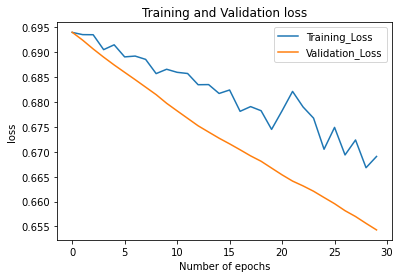

In [94]:
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')

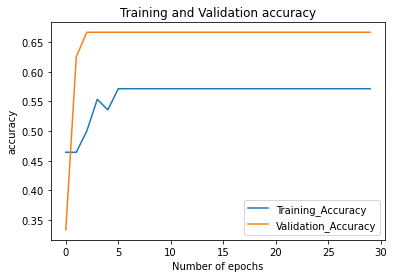

In [95]:
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

In [96]:
# display long string 
pd.options.display.max_colwidth=100
messages[:3]

,message,label
0,"Woy ngentot bayar gak, gw sebar foto2 lu",threat
1,oi jamet bayar gak lo skrg?!,threat
2,hati hati anda saya gak segan mencelakai anda,threat


In [97]:
predict_msg = ["gw bakal bunuh lu sekeluarga","bangsat bayar gak lu kan ngutang babi","weh lu mau kemana ikut dong"]

In [98]:
def predict_spam(predict_msg):
    new_seq = tokenizer.texts_to_sequences(predict_msg)
    padded = pad_sequences(new_seq, maxlen =max_len,
                      padding = padding_type,
                      truncating=trunc_type)
    return (model.predict(padded))

In [99]:
predict_spam(predict_msg)


array([[0.50897855],
       [0.5080546 ],
       [0.5048609 ]], dtype=float32)